# 2. Data Cleaning & EDA

Previamente se ha realizado una catalogacion manual de alrededor de 500 post si el usuario es un repartidor o consumidor en base a la informacion obtenida.

Igualmente se ha menos de 400 se han catalogado segun categoria del post

In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import pos_tag

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier  # Puedes usar cualquier clasificador
from sklearn.metrics import classification_report, accuracy_score
# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


In [2]:
df = pd.read_csv('Datasets/post_reddit_edit_2411.csv')

In [3]:
df.isnull().sum()

created_utc           0
title                 0
self_text           366
type_user          2279
Description        2374
subreddit             0
num_comments          0
score                 0
upvote_ratio          0
url                   0
file_date             0
file_hour             0
file_type             0
is_self             328
link_flair_text    2370
author              348
info_url           1709
media                 0
dtype: int64

In [4]:
# Se eliminas las variables por no disponer de informacion relevante o gran cantidad de nulls
df.drop(columns=['url','file_date','file_hour','file_type','is_self','created_utc','link_flair_text','info_url'], axis=1,inplace=True)    


In [84]:
df.shape

(2726, 20)

In [6]:
df['has_self_text'] = df['self_text'].apply(lambda x: "No" if pd.isnull(x) else "Yes")
df['self_text'] = df['self_text'].apply(lambda x: "No text" if pd.isnull(x) else x)

In [7]:
df['has_self_text'].value_counts()

has_self_text
Yes    2360
No      366
Name: count, dtype: int64

In [8]:
# Update missing values on author
df['has_author'] = df['author'].apply(lambda x: "No" if pd.isnull(x) else 'Yes')
df['author'] = df['author'].apply(lambda x: "Anonymous" if pd.isnull(x) else x)

In [9]:
df.isnull().sum()

created_utc         0
title               0
self_text           0
type_user        2279
Description      2374
subreddit           0
num_comments        0
score               0
upvote_ratio        0
author              0
media               0
has_self_text       0
has_author          0
dtype: int64

In [10]:
#Distribution of  comments based on subreddit
df['subreddit'].value_counts(normalize=True)

subreddit
doordash    0.565297
UberEATS    0.434703
Name: proportion, dtype: float64

In [11]:
stop_words = set(stopwords.words('english')) 
lemmatizer = WordNetLemmatizer()


In [51]:
emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # Emoticonos
                           u"\U0001F300-\U0001F5FF"  # Símbolos y pictogramas
                           u"\U0001F680-\U0001F6FF"  # Transporte y mapas
                           u"\U0001F700-\U0001F77F"  # Alquimia
                           u"\U0001F780-\U0001F7FF"  # Geométricos
                           u"\U0001F800-\U0001F8FF"  # Suplemento de flechas
                           u"\U0001F900-\U0001F9FF"  # Suplemento de emoticonos
                           u"\U0001FA00-\U0001FA6F"  # Variantes adicionales
                           u"\U0001FA70-\U0001FAFF"  # Símbolos adicionales
                           u"\U00002702-\U000027B0"  # Símbolos variados
                           u"\U000024C2-\U0001F251"  # Caracteres adicionales
                           "]+", flags=re.UNICODE)


def extract_emojis(text):
    if pd.isnull(text):
        return []
    return emoji_pattern.findall(text)

# take away em
def remove_emojis(text):
    if pd.isnull(text):
        return text
    return emoji_pattern.sub(r'', text)

# Extract emojis from title and text
df['emojis_title'] = df['title'].apply(extract_emojis)
df['emojis_self_text'] = df['self_text'].apply(extract_emojis)

df['clean_title'] = df['title'].apply(remove_emojis)
df['clean_self_text'] = df['self_text'].apply(remove_emojis)



In [60]:
# Convert in emoji list in str
df['emojis_self_text'] = df['emojis_self_text'].apply(lambda x: " ".join(x) if isinstance(x, list) else "")
df['emojis_title'] = df['emojis_title'].apply(lambda x: " ".join(x) if isinstance(x, list) else "")
df['has_emojis_self_text'] = df['emojis_title'].apply(lambda x: 0 if x=='' else 1)
df['has_emojis_title'] = df['emojis_self_text'].apply(lambda x: 0 if x=='' else 1)

In [66]:

# Función de limpieza y normalización
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('V'):
        return 'v'  # Verbo
    elif treebank_tag.startswith('N'):
        return 'n'  # Sustantivo
    elif treebank_tag.startswith('R'):
        return 'r'  # Adverbio
    elif treebank_tag.startswith('J'):
        return 'a'  # Adjetivo
    else:
        return 'n'  # Default (Sustantivo)

def clean_text(text):
    if pd.isnull(text):  # Manejo de texto nulo
        return ""
    
    # Convertir a minúsculas
    text = text.lower()
    
    # Eliminar URLs
    text = re.sub(r'http\S+|www.\S+', '', text)
    
    # Quitar caracteres especiales y números
    text = re.sub(r'[^a-z\s]', '', text)
    
    # Tokenización
    tokens = word_tokenize(text)
    
    # Etiquetar las partes del discurso (POS)
    pos_tags = pos_tag(tokens)
    
    # Eliminar stopwords y lematizar usando POS
    tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) 
              for word, pos in pos_tags if word not in stop_words]
    
    return " ".join(tokens)

# Aplicar limpieza al título y texto
df['clean_title'] = df['title'].apply(clean_text)
df['clean_self_text'] = df['self_text'].apply(clean_text)

# Ver los resultados
df[['title', 'clean_title', 'self_text', 'clean_self_text']].head()

,title,clean_title,self_text,clean_self_text
0,"Dear dashers, stop putting food in front of sc...",dear dashers stop put food front screen door,This happens all the time! My screen door open...,happen time screen door open lock cant access ...
1,If I would have died like this,would die like,The house was nice though lol,house nice though lol
2,grocery order taking almost 5 hours,grocery order take almost hour,i placed a grocery order 4.5 hours ago and the...,place grocery order hour ago dasher finally wa...
3,Holy peak pay batman,holy peak pay batman,by far the most promos ive seen in portland or...,far promos ive see portland oregon
4,Higher peak pay = Over saturated market,high peak pay saturated market,Higher peak pay\n Oversaturated Market\n ...,high peak pay oversaturated market competition...


In [ ]:
def tokenizar()
    tokens = text.split()
    
    # Eliminar stopwords y lematizar
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    
    return " ".join(tokens)

In [ ]:
df['clean_title'] = df['title'].apply(clean_text)
df['clean_self_text'] = df['self_text'].apply(clean_text)

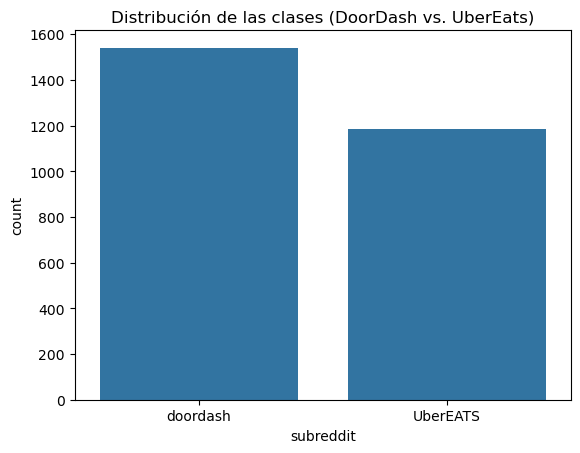

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# Contar el número de muestras por clase
sns.countplot(x='subreddit', data=df)
plt.title('Distribución de las clases (DoorDash vs. UberEats)')
plt.show()

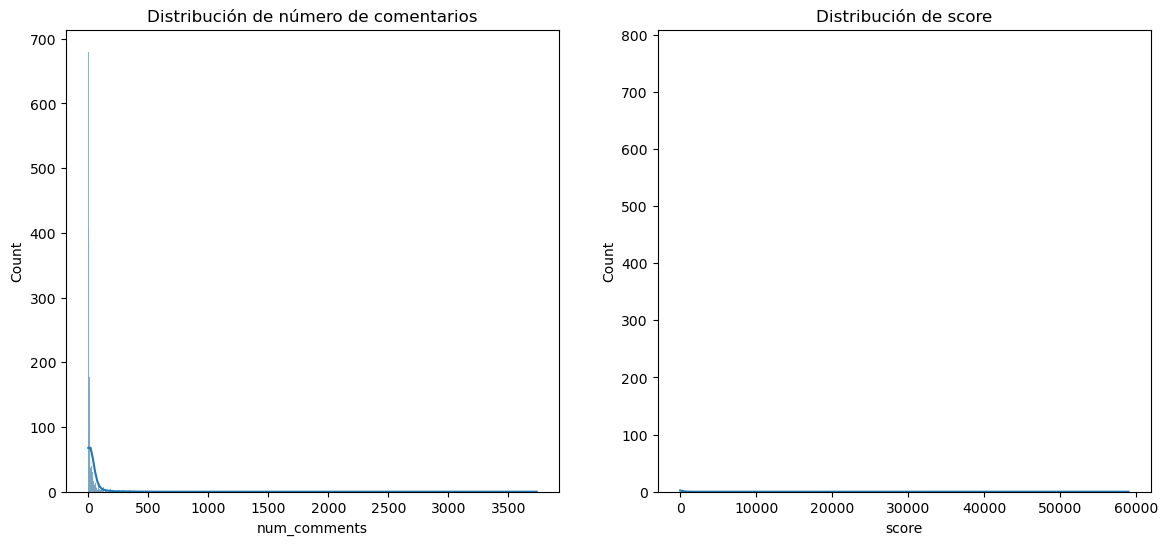

In [37]:
# Histograma para ver la distribución de 'num_comments' y 'score'
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.histplot(df['num_comments'], kde=True, ax=axes[0]).set_title('Distribución de número de comentarios')
sns.histplot(df['score'], kde=True, ax=axes[1]).set_title('Distribución de score')

plt.show()

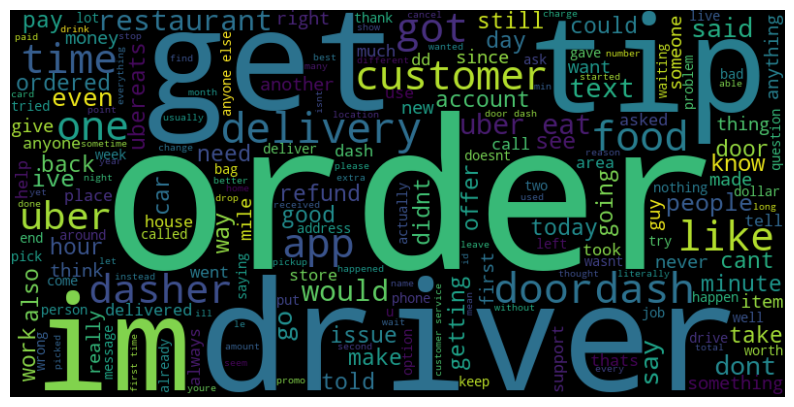

In [67]:
from wordcloud import WordCloud

# Generar una nube de palabras para 'clean_title' o 'clean_self_text'
text = ' '.join(df['full_text'])
wordcloud = WordCloud(stopwords='english', width=800, height=400).generate(text)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [82]:
df['subreddit'].value_counts()

subreddit
doordash    1541
UberEATS    1185
Name: count, dtype: int64

In [83]:

# Filtrar los datos para DoorDash y UberEats
df_doordash = df[df['subreddit'] == 'doordash']
df_ubereats = df[df['subreddit'] == 'UberEATS']
df_doordash_clean = df_doordash[df_doordash['clean_self_text'].notnull() & (df_doordash['clean_self_text'] != '')]
df_ubereats_clean = df_ubereats[df_ubereats['clean_self_text'].notnull() & (df_ubereats['clean_self_text'] != '')]

# Función para obtener las palabras más comunes
def get_word_freq(df, column='clean_self_text', top_n=50):
    vectorizer = CountVectorizer(stop_words='english', max_features=top_n)
    X = vectorizer.fit_transform(df[column].dropna())  # Asegúrate de que no haya valores nulos
    
    # Obtener las palabras y sus frecuencias
    word_freq = dict(zip(vectorizer.get_feature_names_out(), X.sum(axis=0).tolist()[0]))
    
    # Convertir en DataFrame
    word_freq_df = pd.DataFrame(list(word_freq.items()), columns=['word', 'frequency'])
    
    # Ordenar por frecuencia descendente
    word_freq_df = word_freq_df.sort_values(by='frequency', ascending=False)
    
    return word_freq_df

# Obtener las palabras más comunes para DoorDash y UberEats
door_dash_self_freq_df = get_word_freq(df_doordash_clean,'clean_self_text')
ubereats_self_freq_df = get_word_freq(df_ubereats_clean,'clean_self_text')
door_dash_title_freq_df = get_word_freq(df_doordash,'clean_title')
ubereats_title_freq_df = get_word_freq(df_ubereats,'clean_title')

# Guardar los DataFrames en archivos CSV
door_dash_self_freq_df.to_csv('door_dash_self_freq_df.csv', index=False)
ubereats_self_freq_df.to_csv('ubereats_self_freq_df.csv', index=False)
door_dash_title_freq_df.to_csv('door_dash_title_freq_df.csv', index=False)
ubereats_title_freq_df.to_csv('ubereats_title_freq_df.csv', index=False)

# Mostrar las primeras filas de los resultados
print("Top palabras de DoorDash:")
print(door_dash_self_freq_df.head())

print("\nTop palabras de UberEats:")
print(ubereats_self_freq_df.head())


Top palabras de DoorDash:
        word  frequency
30     order       1429
20        im        617
43       tip        551
42      time        512
13  doordash        487

Top palabras de UberEats:
      word  frequency
28   order       1619
43    uber        888
14  driver        626
35     say        538
19      im        508


In [74]:
vectorizer = CountVectorizer(stop_words='english', max_features=50)  # Solo las 100 palabras más comunes
X = vectorizer.fit_transform(df['clean_self_text'].dropna())  # Asegúrate de que no haya valores nulos

# Obtener las palabras y sus frecuencias
word_freq = dict(zip(vectorizer.get_feature_names_out(), X.sum(axis=0).tolist()[0]))

# Imprimir las palabras más comunes y sus frecuencias
print(sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:10])

[('order', 3048), ('im', 1125), ('say', 998), ('time', 972), ('tip', 924), ('driver', 920), ('uber', 918), ('food', 835), ('like', 792), ('delivery', 780)]


In [75]:
word_freq
word_freq_df = pd.DataFrame(list(word_freq.items()), columns=['word', 'frequency'])
word_freq_df = word_freq_df.sort_values(by='frequency', ascending=False)

word_freq_df.to_csv('word_frequency_self.csv', index=False)

In [98]:

vectorizer = CountVectorizer(stop_words='english', max_features=50)  # Solo las 100 palabras más comunes
X = vectorizer.fit_transform(df['clean_self_text'].dropna())  # Asegúrate de que no haya valores nulos

# Obtener las palabras y sus frecuencias
word_freq = dict(zip(vectorizer.get_feature_names_out(), X.sum(axis=0).tolist()[0]))

# Imprimir las palabras más comunes y sus frecuencias
print(sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:10])

[('order', 3048), ('im', 1125), ('say', 998), ('time', 972), ('tip', 924), ('driver', 920), ('uber', 918), ('food', 835), ('like', 792), ('delivery', 780)]


In [99]:
word_freq
word_freq_df = pd.DataFrame(list(word_freq.items()), columns=['word', 'frequency'])
word_freq_df = word_freq_df.sort_values(by='frequency', ascending=False)

word_freq_df.to_csv('word_frequency_self.csv', index=False)

In [68]:
vectorizer = CountVectorizer(stop_words='english', max_features=50)  # Solo las 100 palabras más comunes
X = vectorizer.fit_transform(df['clean_title'].dropna())  # Asegúrate de que no haya valores nulos

# Obtener las palabras y sus frecuencias
word_freq = dict(zip(vectorizer.get_feature_names_out(), X.sum(axis=0).tolist()[0]))

# Imprimir las palabras más comunes y sus frecuencias
print(sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:10])

[('order', 406), ('driver', 227), ('uber', 221), ('doordash', 199), ('delivery', 178), ('tip', 177), ('customer', 150), ('food', 106), ('pay', 105), ('dash', 103)]


In [73]:
word_freq
word_freq_df = pd.DataFrame(list(word_freq.items()), columns=['word', 'frequency'])
word_freq_df = word_freq_df.sort_values(by='frequency', ascending=False)

word_freq_df.to_csv('word_frequency.csv', index=False)

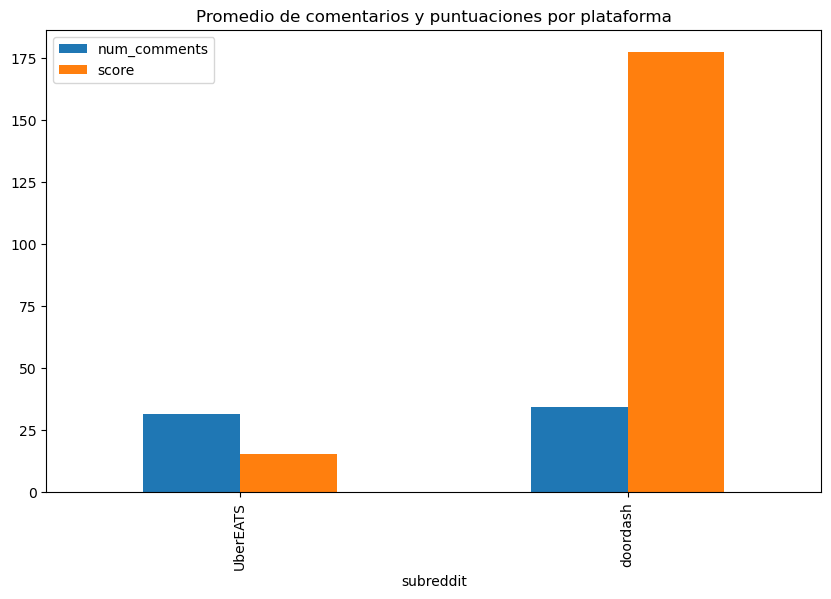

In [43]:
# Comparar la media de 'num_comments' y 'score' entre plataformas
df.groupby('subreddit')[['num_comments', 'score']].mean().plot(kind='bar', figsize=(10, 6))
plt.title('Promedio de comentarios y puntuaciones por plataforma')
plt.show()

In [85]:
# Paso 1: Contar el número de palabras en el título y en el texto limpio
df['word_count_title'] = df['clean_title'].apply(lambda x: len(x.split()))
df['word_count_self_text'] = df['clean_self_text'].apply(lambda x: len(x.split()))

# Paso 2: Agrupar por subreddit y calcular estadísticas
word_count_stats_title = df.groupby('subreddit')['word_count_title'].agg(['mean', 'median', 'min', 'max', 'std'])
word_count_stats_self_text = df.groupby('subreddit')['word_count_self_text'].agg(['mean', 'median', 'min', 'max', 'std'])

# Paso 3: Mostrar los resultados
print("Estadísticas de palabras en el título por subreddit:")
print(word_count_stats_title)

print("\nEstadísticas de palabras en el texto por subreddit:")
print(word_count_stats_self_text)

Estadísticas de palabras en el título por subreddit:
               mean  median  min  max       std
subreddit                                      
UberEATS   4.622785     4.0    0   30  3.253167
doordash   4.359507     4.0    0   27  3.201545

Estadísticas de palabras en el texto por subreddit:
                mean  median  min  max        std
subreddit                                        
UberEATS   44.711392    30.0    0  476  50.459370
doordash   33.299805    20.0    0  528  41.408336


In [89]:
df.groupby('subreddit')['word_count_title'].describe(percentiles=[.25, .5, .75])


,count,mean,std,min,25%,50%,75%,max
subreddit,,,,,,,,
UberEATS,1185.0,4.622785,3.253167,0.0,3.0,4.0,6.0,30.0
doordash,1541.0,4.359507,3.201545,0.0,2.0,4.0,5.0,27.0


In [97]:
from scipy.stats import ttest_ind

# Paso 1: Filtrar los datos por subreddit
doordash_data = df[df['subreddit'] == 'Doordash']['word_count_title']
ubereats_data = df[df['subreddit'] == 'UberEATS']['word_count_title']

# Paso 2: Realizar el t-test de Student
t_stat, p_value = ttest_ind(doordash_data.dropna(), ubereats_data.dropna())  # .dropna() para eliminar valores nulos

# Paso 3: Interpretar el resultado
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Interpretación:
if p_value < 0.05:
    print("Rechazamos la hipótesis nula, hay una diferencia significativa entre los recuentos de palabras.")
else:
    print("No rechazamos la hipótesis nula, no hay diferencia significativa entre los recuentos de palabras.")

T-statistic: nan
P-value: nan
No rechazamos la hipótesis nula, no hay diferencia significativa entre los recuentos de palabras.


In [96]:
# Paso 1: Filtrar los datos por subreddit
doordash_data = df[df['subreddit'] == 'doordash']['word_count_self_text']
ubereats_data = df[df['subreddit'] == 'UberEATS']['word_count_self_text']

# Paso 2: Realizar el t-test de Student
t_stat, p_value = ttest_ind(doordash_data.dropna(), ubereats_data.dropna())  # .dropna() para eliminar valores nulos

# Paso 3: Interpretar el resultado
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Interpretación:
if p_value < 0.05:
    print("Rechazamos la hipótesis nula, hay una diferencia significativa entre los recuentos de palabras.")
else:
    print("No rechazamos la hipótesis nula, no hay diferencia significativa entre los recuentos de palabras.")

T-statistic: -6.482210868556175
P-value: 1.0692036794861551e-10
Rechazamos la hipótesis nula, hay una diferencia significativa entre los recuentos de palabras.


In [88]:
df.groupby('subreddit')['word_count_self_text'].describe(percentiles=[.25, .5, .75])

,count,mean,std,min,25%,50%,75%,max
subreddit,,,,,,,,
UberEATS,1185.0,44.711392,50.459370,0.0,13.0,30.0,59.0,476.0
doordash,1541.0,33.299805,41.408336,0.0,6.0,20.0,44.0,528.0


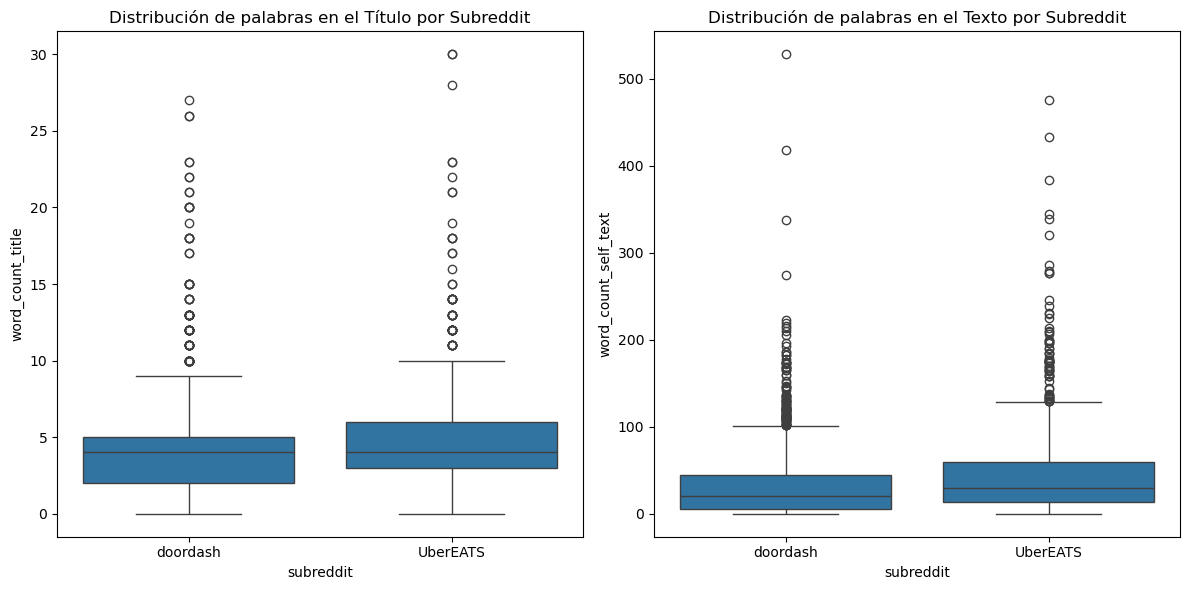

In [86]:
import seaborn as sns

# Paso 1: Calcular los percentiles, mediana y otros valores
# Para el título
word_count_stats_title = df.groupby('subreddit')['word_count_title'].describe(percentiles=[.25, .5, .75])

# Para el texto
word_count_stats_self_text = df.groupby('subreddit')['word_count_self_text'].describe(percentiles=[.25, .5, .75])

# Paso 2: Crear los gráficos de caja
plt.figure(figsize=(12, 6))

# Gráfico de palabras en el título por subreddit
plt.subplot(1, 2, 1)
sns.boxplot(x='subreddit', y='word_count_title', data=df)
plt.title('Distribución de palabras en el Título por Subreddit')

# Gráfico de palabras en el texto por subreddit
plt.subplot(1, 2, 2)
sns.boxplot(x='subreddit', y='word_count_self_text', data=df)
plt.title('Distribución de palabras en el Texto por Subreddit')

# Mostrar el gráfico
plt.tight_layout()
plt.show()

In [104]:
from nltk.sentiment import SentimentIntensityAnalyzer

# Inicializar el analizador de sentimientos
sia = SentimentIntensityAnalyzer()

# Función para obtener el puntaje de sentimiento
def analyze_sentiment(text):
    # Asegurarse de que el texto no sea nulo
    if pd.isnull(text):
        return {'pos': 0, 'neu': 0, 'neg': 0, 'compound': 0}
    
    # Obtener los valores de sentimiento
    sentiment = sia.polarity_scores(text)
    return sentiment

# Aplicar el análisis de sentimiento a 'clean_title' y 'clean_self_text'
df['sentiment_title'] = df['clean_title'].apply(analyze_sentiment)
df['sentiment_self_text'] = df['clean_self_text'].apply(analyze_sentiment)

# Extraer los puntajes de sentimiento de las columnas de diccionario
df['sentiment_title_pos'] = df['sentiment_title'].apply(lambda x: x['pos'])
df['sentiment_title_neg'] = df['sentiment_title'].apply(lambda x: x['neg'])
df['sentiment_title_neu'] = df['sentiment_title'].apply(lambda x: x['neu'])
df['sentiment_title_compound'] = df['sentiment_title'].apply(lambda x: x['compound'])

df['sentiment_self_text_pos'] = df['sentiment_self_text'].apply(lambda x: x['pos'])
df['sentiment_self_text_neg'] = df['sentiment_self_text'].apply(lambda x: x['neg'])
df['sentiment_self_text_neu'] = df['sentiment_self_text'].apply(lambda x: x['neu'])
df['sentiment_self_text_compound'] = df['sentiment_self_text'].apply(lambda x: x['compound'])

In [107]:
# Agrupar por subreddit y calcular estadísticas descriptivas de 'compound'
subreddit_sentiment = df.groupby('subreddit')['sentiment_self_text_compound'].describe()
print(subreddit_sentiment)

            count      mean       std     min     25%  50%     75%     max
subreddit                                                                 
UberEATS   1185.0  0.082245  0.544998 -0.9900 -0.3182  0.0  0.5574  0.9955
doordash   1541.0  0.081187  0.497162 -0.9845 -0.1779  0.0  0.4588  0.9943


In [113]:
# Agrupar por subreddit y calcular estadísticas descriptivas de 'compound'
subreddit_sentiment = df.groupby('subreddit')['sentiment_self_text_neg'].describe()
print(subreddit_sentiment)

            count      mean       std  min  25%    50%    75%    max
subreddit                                                           
UberEATS   1185.0  0.105363  0.112602  0.0  0.0  0.091  0.161  1.000
doordash   1541.0  0.093454  0.113676  0.0  0.0  0.065  0.151  0.778


In [122]:
# Paso 1: Filtrar los datos por subreddit
doordash_data = df[df['subreddit'] == 'doordash']['sentiment_title_compound']
ubereats_data = df[df['subreddit'] == 'UberEATS']['sentiment_title_compound']

# Paso 2: Realizar el t-test de Student
t_stat, p_value = ttest_ind(doordash_data.dropna(), ubereats_data.dropna())  # .dropna() para eliminar valores nulos

# Paso 3: Interpretar el resultado
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Interpretación:
if p_value < 0.05:
    print("Rechazamos la hipótesis nula, hay una diferencia significativa entre los recuentos de palabras.")
else:
    print("No rechazamos la hipótesis nula, no hay diferencia significativa entre los recuentos de palabras.")

T-statistic: 1.5378099863956767
P-value: 0.12421122375569905
No rechazamos la hipótesis nula, no hay diferencia significativa entre los recuentos de palabras.


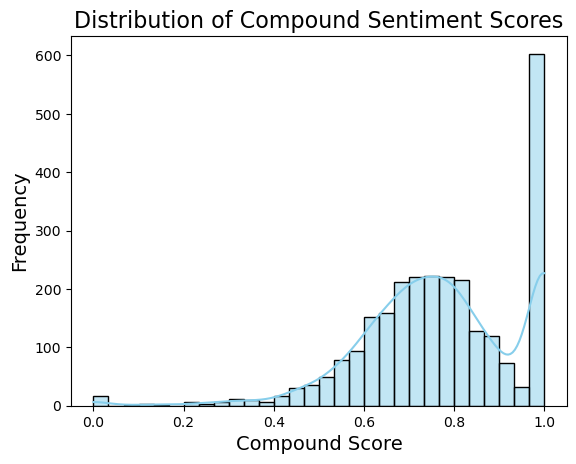

In [119]:
sns.histplot(df['sentiment_self_text_neu'], bins=30, kde=True, color='skyblue')

# Add titles and labels
plt.title('Distribution of Compound Sentiment Scores', fontsize=16)
plt.xlabel('Compound Score', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Show the plot
plt.show()

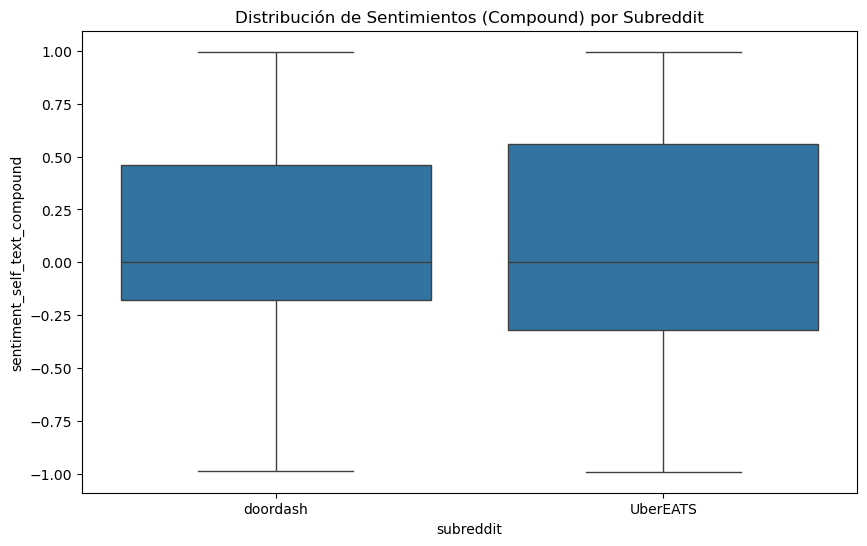

In [112]:
import seaborn as sns

# Boxplot para visualizar la distribución de sentimientos por subreddit
plt.figure(figsize=(10, 6))
sns.boxplot(x='subreddit', y='sentiment_self_text_compound', data=df)
plt.title('Distribución de Sentimientos (Compound) por Subreddit')
plt.show()

In [121]:
df.to_csv('post_reddit_eda.csv', index=False)

In [124]:
df['has_media'] = df['media'].apply(lambda x: 0 if x=='n' else 1)

In [131]:
def review_sig(var):
# Paso 1: Filtrar los datos por subreddit
    doordash_data = df[df['subreddit'] == 'doordash'][var]
    ubereats_data = df[df['subreddit'] == 'UberEATS'][var]
    
    # Paso 2: Realizar el t-test de Student
    t_stat, p_value = ttest_ind(doordash_data.dropna(), ubereats_data.dropna())  # .dropna() para eliminar valores nulos
    
    # Paso 3: Interpretar el resultado
    print(f"T-statistic: {t_stat}")
    print(f"P-value: {p_value}")
    
    # Interpretación:
    print(var)
    if p_value < 0.05:
        print("Rechazamos la hipótesis nula, hay una diferencia significativa entre los recuentos de palabras.")
    else:
        print("No rechazamos la hipótesis nula, no hay diferencia significativa entre los recuentos de palabras.")

review_sig('has_media')
review_sig('num_comments')
review_sig('score')
review_sig('sentiment_self_text_pos')
review_sig('sentiment_title_pos')
review_sig('sentiment_title_neu')
review_sig('sentiment_self_text_neu')

T-statistic: 11.454285754328154
P-value: 1.0589531726654247e-29
has_media
Rechazamos la hipótesis nula, hay una diferencia significativa entre los recuentos de palabras.
T-statistic: 0.42142007078508287
P-value: 0.6734816160416922
num_comments
No rechazamos la hipótesis nula, no hay diferencia significativa entre los recuentos de palabras.
T-statistic: 2.423286621607568
P-value: 0.015445551799517985
score
Rechazamos la hipótesis nula, hay una diferencia significativa entre los recuentos de palabras.
T-statistic: -0.44621756404499446
P-value: 0.655475563319626
sentiment_self_text_pos
No rechazamos la hipótesis nula, no hay diferencia significativa entre los recuentos de palabras.
T-statistic: 1.9231976795834866
P-value: 0.054559355295802144
sentiment_title_pos
No rechazamos la hipótesis nula, no hay diferencia significativa entre los recuentos de palabras.
T-statistic: -1.2371648597764127
P-value: 0.21613252361661536
sentiment_title_neu
No rechazamos la hipótesis nula, no hay diferencia

In [138]:
grouped = df.groupby(['subreddit', 'has_media']).size().reset_index(name='count')
grouped



,subreddit,has_media,count
0,UberEATS,0,883
1,UberEATS,1,302
2,doordash,0,826
3,doordash,1,715


In [128]:
df.dtypes

created_utc                       int64
title                            object
self_text                        object
type_user                        object
Description                      object
subreddit                        object
num_comments                      int64
score                             int64
upvote_ratio                    float64
author                           object
media                            object
has_self_text                    object
has_author                       object
emojis_title                     object
emojis_self_text                 object
clean_title                      object
clean_self_text                  object
full_text                        object
has_emojis_self_text              int64
has_emojis_title                  int64
word_count_title                  int64
word_count_self_text              int64
sentiment_title                  object
sentiment_self_text              object
sentiment_title_pos             float64
